In [1]:
import numpy as np
import polars as pl
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm

In [2]:
strata_config = {
    "platform": {
        "ios":     {"proportion": 0.4, "mu_factor": 2.2,  "std_factor": 1, "effect": 1.05},
        "android": {"proportion": 0.6, "mu_factor": 0.8,  "std_factor": 1.2,  "effect": 1.02},
    },
    "country": {
        "US": {"proportion": 0.5, "mu_factor": 1.5,  "std_factor": 1, "effect": 1.03},
        "EU": {"proportion": 0.3, "mu_factor": 1,  "std_factor": 1,  "effect": 1.05},
        "RU": {"proportion": 0.2, "mu_factor": 0.7,  "std_factor": 1,  "effect": 1.01},
    },
    "is_payer": {
        "payer":     {"proportion": 0.1, "mu_factor": 3, "std_factor": 0.5, "effect": 1.08},
        "non_payer": {"proportion": 0.9, "mu_factor": 0.5,  "std_factor": 1,  "effect": 1.01},
    }
}

In [3]:
def generate_random_data(strata_config, sample_size, population_size, mu_base=1, std_base=1, stratified=False):
    strata_names = list(strata_config.keys())
    strata_values = [list(v.keys()) for v in strata_config.values()]
    dfs = []
    for combo in product(*strata_values):
        proportion = np.prod([
            strata_config[col][val]["proportion"]
            for col, val in zip(strata_names, combo)
        ])
        mu = mu_base * np.prod([
            strata_config[col][val]["mu_factor"]
            for col, val in zip(strata_names, combo)
        ])
        std = std_base * np.prod([
            strata_config[col][val]["std_factor"]
            for col, val in zip(strata_names, combo)
        ])

        n_stratum = max(1, int(proportion * population_size))
        data = dict(zip(strata_names, combo))
        data['metric'] = np.random.normal(mu, std, n_stratum)
        dfs.append(pl.DataFrame(data))

    population = pl.concat(dfs)
    
    if stratified:
        return stratified_sample(population, strata_names, sample_size)
    else:
        return population.sample(sample_size)

In [4]:
def calculate_stratified_mean(df, strata_config):
    strata_names = list(strata_config.keys())
    strata_values = [list(v.keys()) for v in strata_config.values()]
    stratified_mean = 0
    for combo in product(*strata_values):
        proportion = np.prod([
            strata_config[col][val]["proportion"]
            for col, val in zip(strata_names, combo)
        ])
        mask = pl.lit(True)
        for col, val in zip(strata_names, combo):
            mask = mask & (pl.col(col) == val)
        
        stratum_mean = df.filter(mask)["metric"].mean()
        stratified_mean += proportion * stratum_mean
    
    return stratified_mean

  0%|          | 0/1000 [00:00<?, ?it/s]

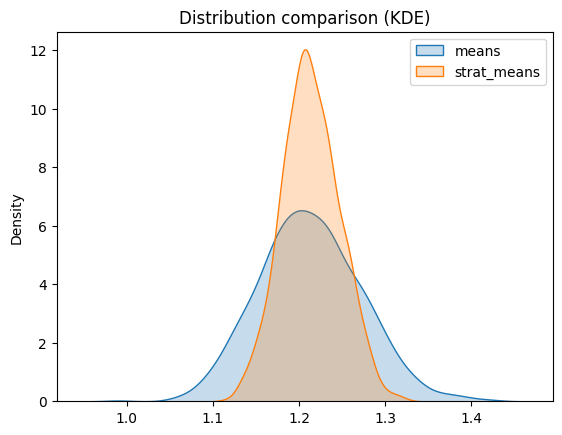

In [5]:
means = []
strat_means = []
for _ in trange(1000):
    df = generate_random_data(strata_config, 1000, 100000)
    means.append(df['metric'].mean())
    strat_means.append(calculate_stratified_mean(df, strata_config))

plt.figure()
sns.kdeplot(means, fill=True)
sns.kdeplot(strat_means, fill=True)
plt.legend(["means", "strat_means"])
plt.title("Distribution comparison (KDE)")
plt.show()

In [6]:
def stratified_sample(df, strata_cols, sample_size):
    total = len(df)
    samples = []
    for group in df.partition_by(strata_cols):
        n = max(1, round(len(group) / total * sample_size))
        samples.append(group.sample(n=n))
    return pl.concat(samples)

In [7]:
df = generate_random_data(strata_config, 100, 1000, stratified=False)
df.group_by("is_payer").agg(
    pl.len().alias("count")
).with_columns(
    (pl.col("count") / pl.col("count").sum()).alias("share")
)

is_payer,count,share
str,u32,f64
"""payer""",16,0.16
"""non_payer""",84,0.84


In [8]:
df = generate_random_data(strata_config, 100, 1000, stratified=True)
df.group_by("is_payer").agg(
    pl.len().alias("count")
).with_columns(
    (pl.col("count") / pl.col("count").sum()).alias("share")
)

is_payer,count,share
str,u32,f64
"""non_payer""",90,0.9
"""payer""",10,0.1
